# 0.0 IMPORTS

In [30]:
import pandas   as pd
import numpy    as np
import seaborn  as sns

import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders       import TargetEncoder
from feature_engine.encoding import CountFrequencyEncoder

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading dataset

In [4]:
data_raw = pd.read_csv('../data/raw/train.csv')

In [5]:
data_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 ANÁLISE DESCRITIVA

In [6]:
df1 = data_raw.copy()

In [7]:
# columns in snakecase
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1 Data informations

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.2 Análise Descritiva

In [9]:
# numerical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical features
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.2.1 Atributos Numéricos

In [10]:
# Tendência Central - média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 FEATURE ENGINEERING

In [11]:
df2 = df1.copy()

In [12]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else 'below_1_year')
# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 FILTRAGEM DOS DADOS

In [13]:
df3 = df2.copy()

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [14]:
df4 = df3.copy()

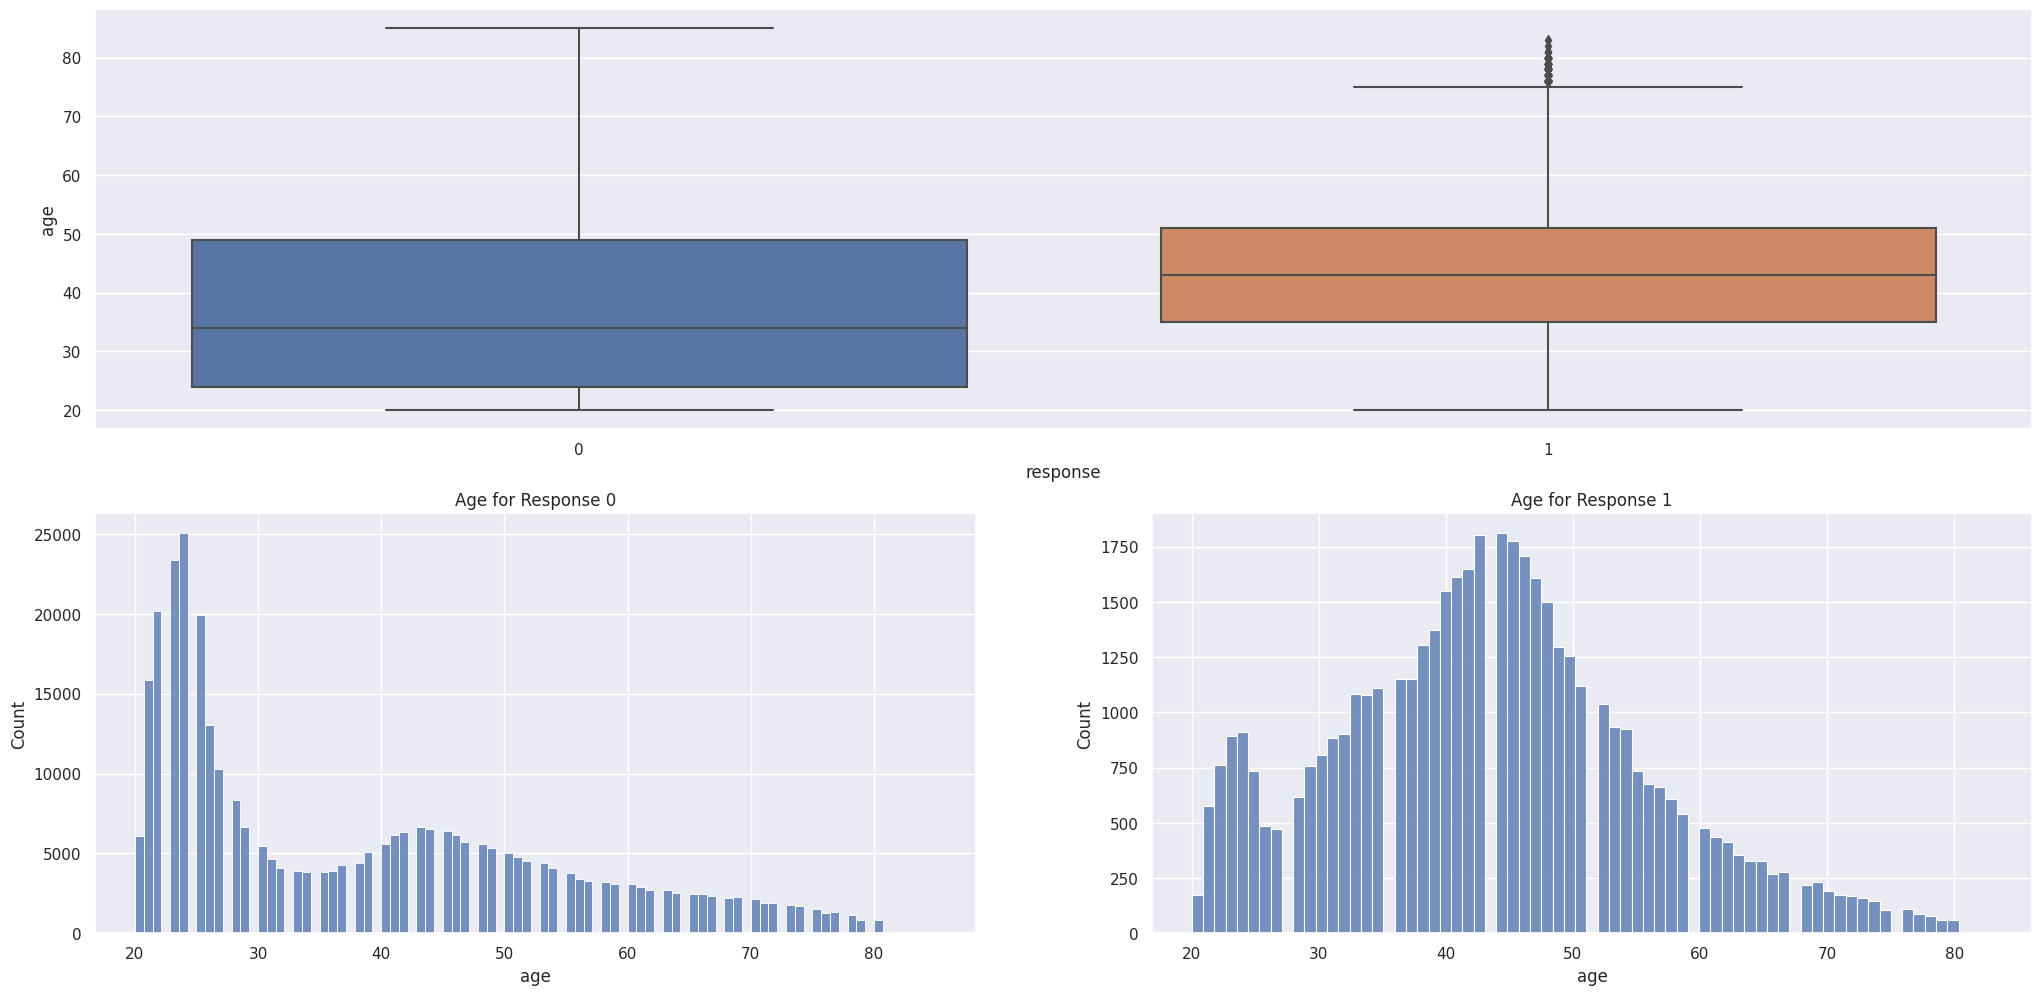

In [15]:
# 'age'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='age', data=df4, ax=ax1)

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='age', ax=ax2)
plt.title('Age for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='age', ax=ax3)
plt.title('Age for Response 1');

gender,Female,Male
response,,
0,0.469006,0.530994
1,0.389317,0.610683


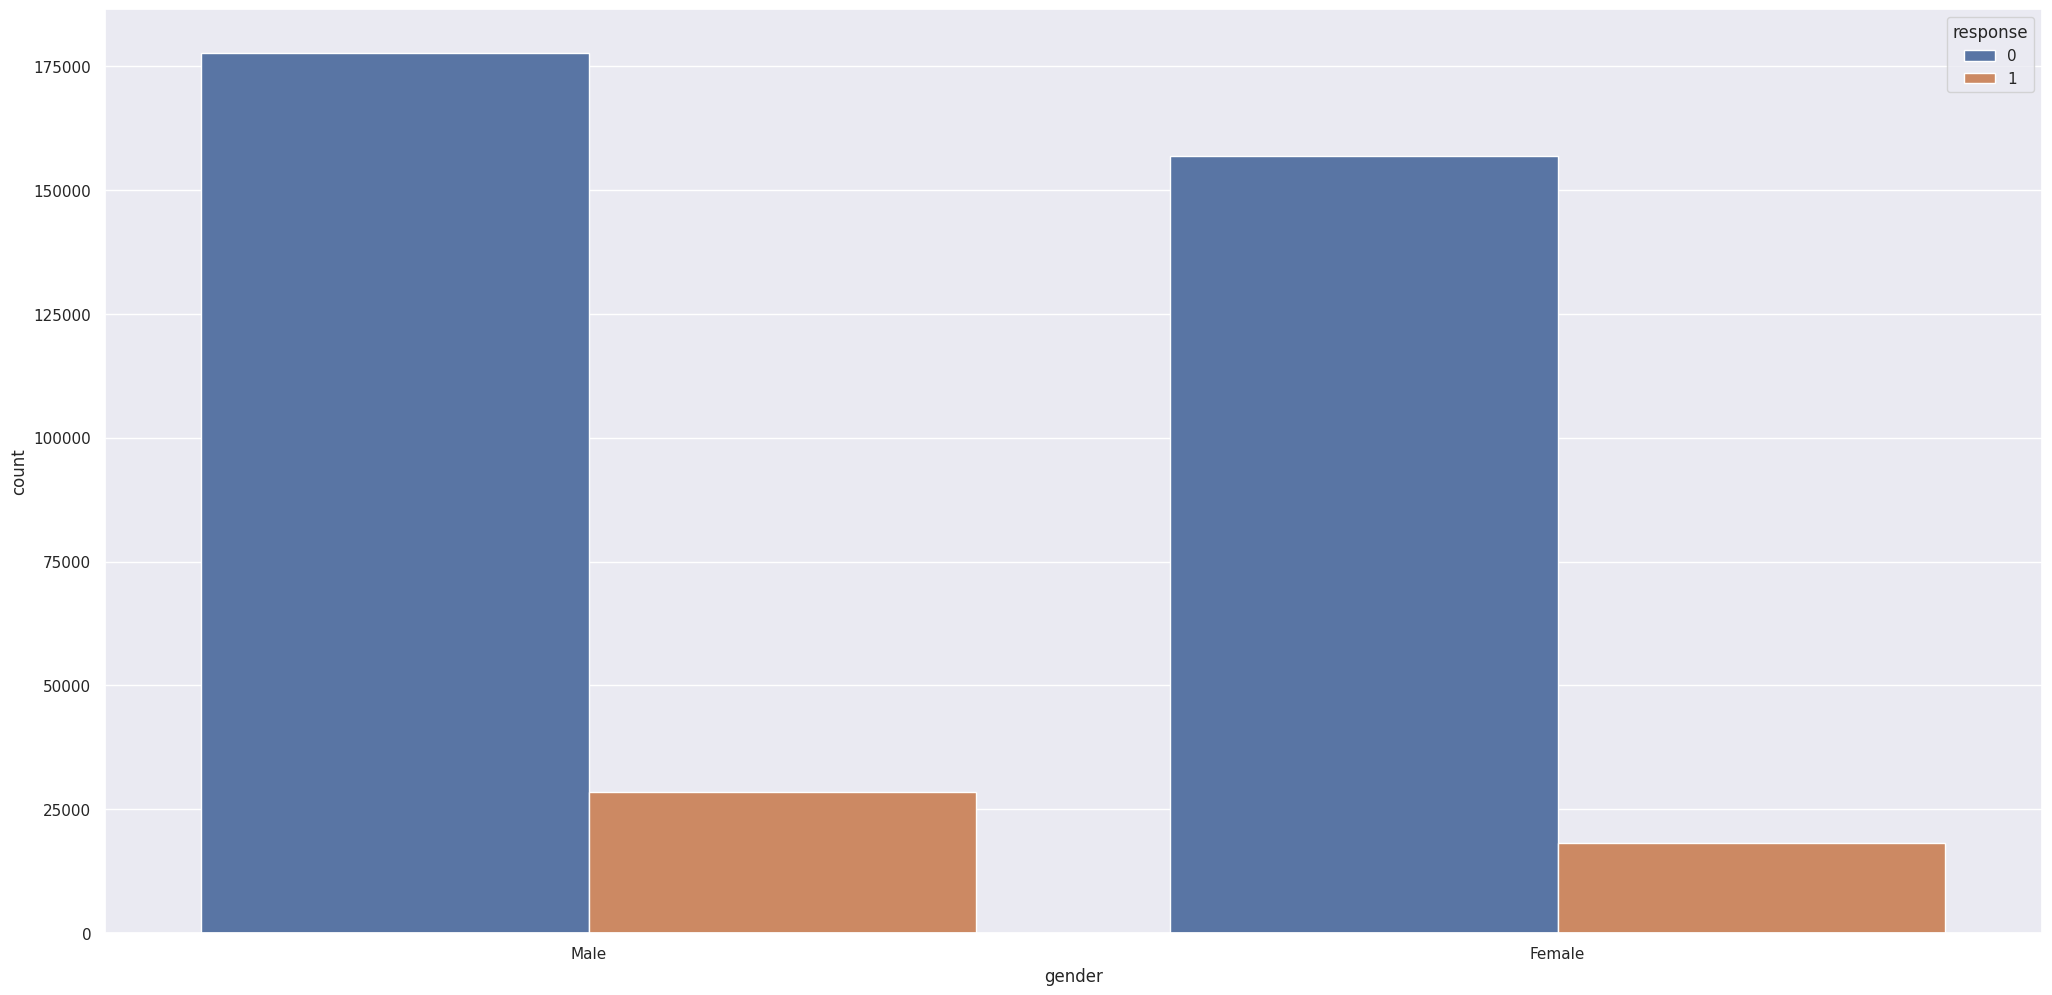

In [16]:
# 'gender'
sns.countplot(x=df4['gender'], hue=df4['response'])

pd.crosstab(df4['response'], df4['gender']).apply(lambda x: x/x.sum(), axis=1)

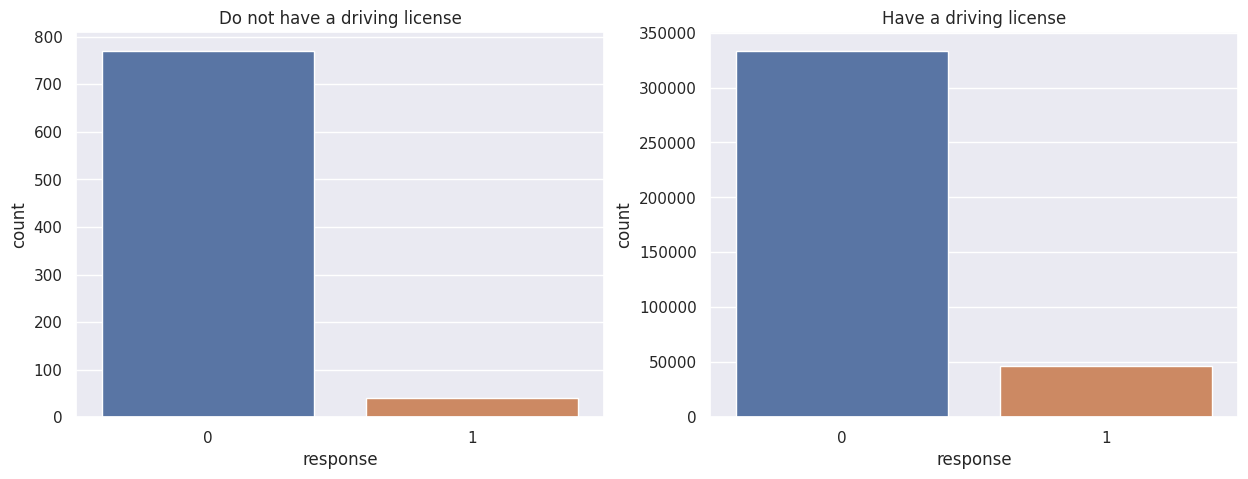

In [17]:
# 'driving_license'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['driving_license'] == 0], ax=ax1)
plt.title('Do not have a driving license')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['driving_license'] == 1], ax=ax2)
plt.title('Have a driving license');

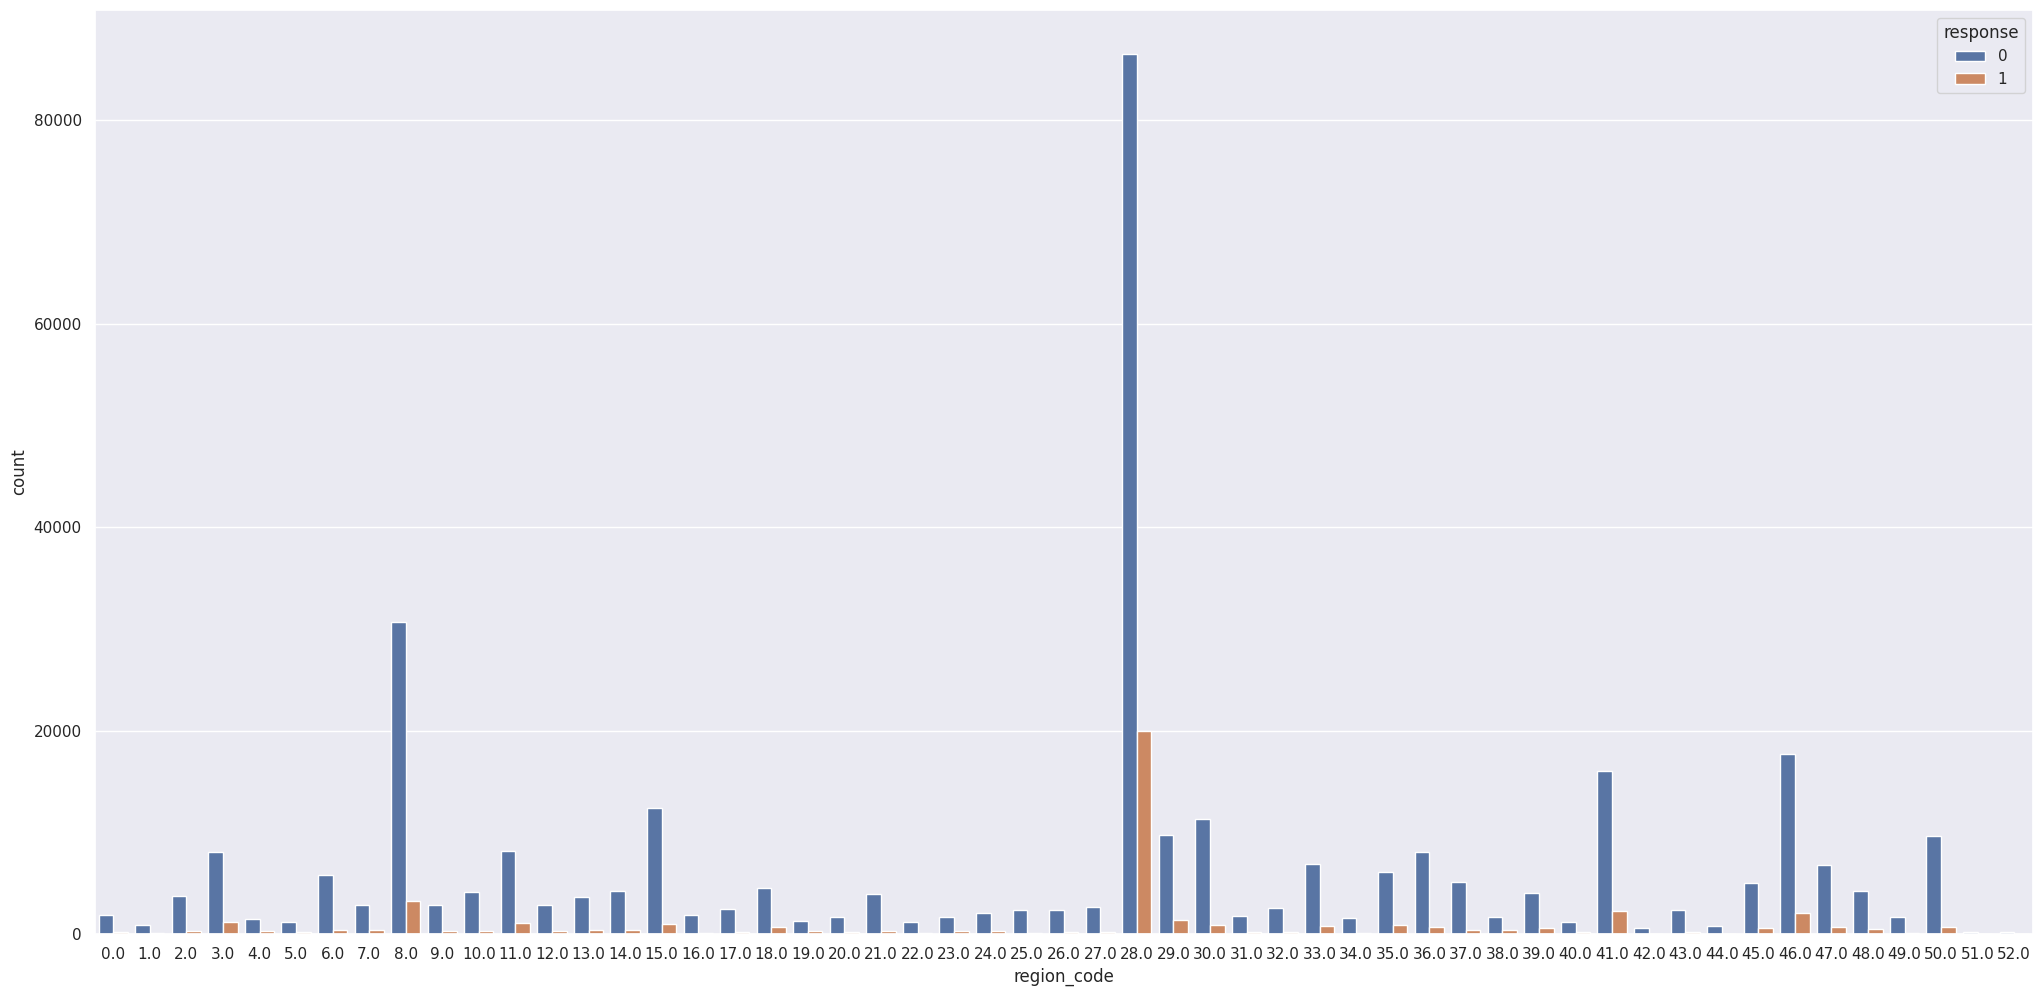

In [18]:
# 'region_code'
sns.countplot(x='region_code', hue='response', data=df4);

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


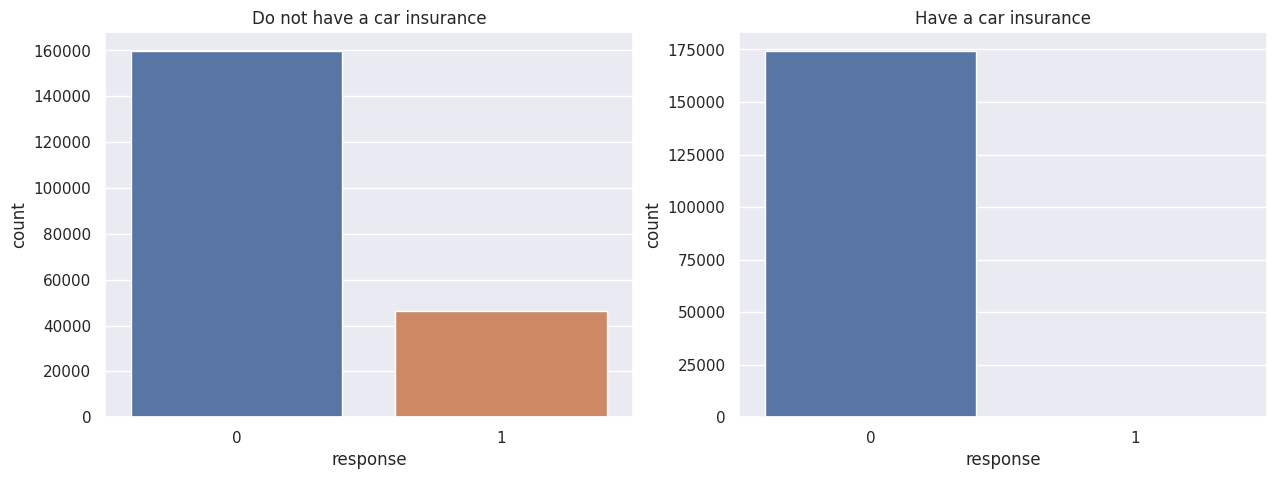

In [19]:
# 'previously_insured'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 0], ax=ax1)
plt.title('Do not have a car insurance')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 1], ax=ax2)
plt.title('Have a car insurance');

# percentage
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

In [20]:
# 'vehicle_age'
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


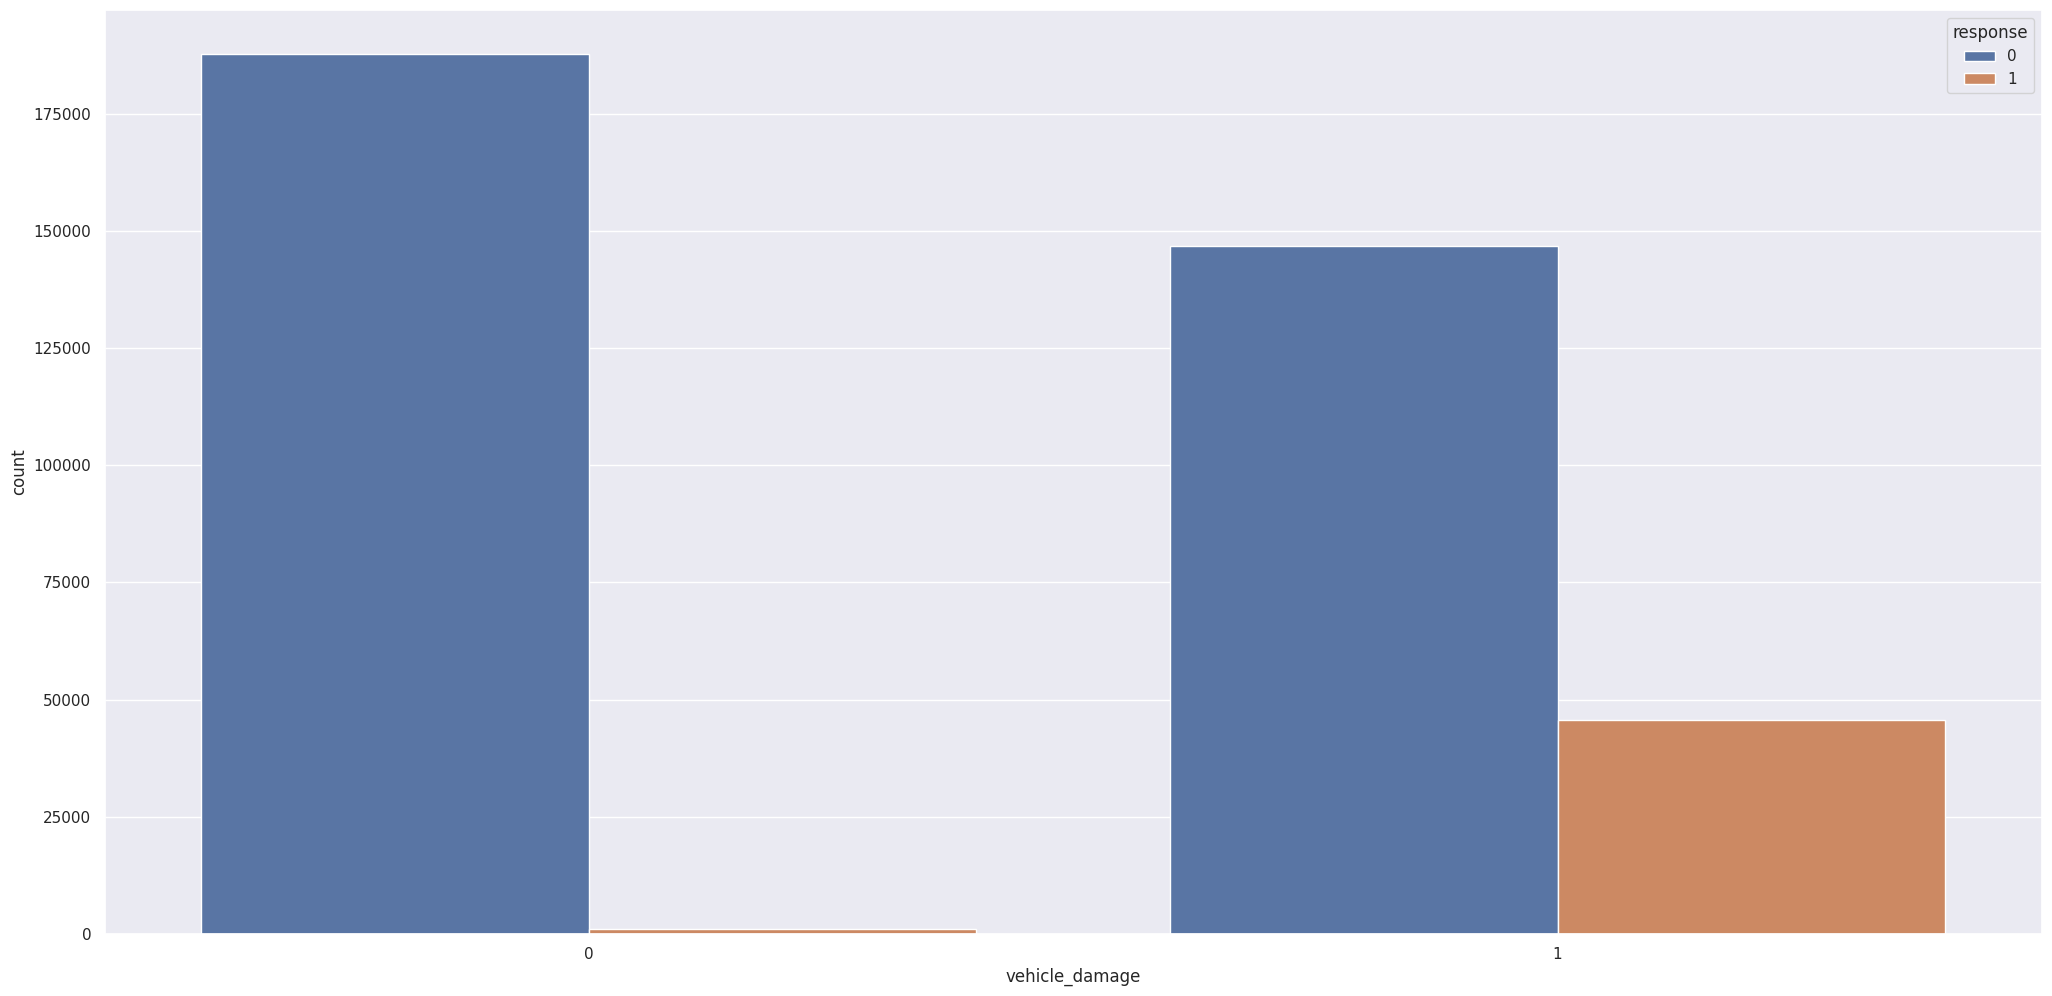

In [21]:
# 'vehicle_damage'
sns.countplot(x=df4['vehicle_damage'], hue=df4['response'])

pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

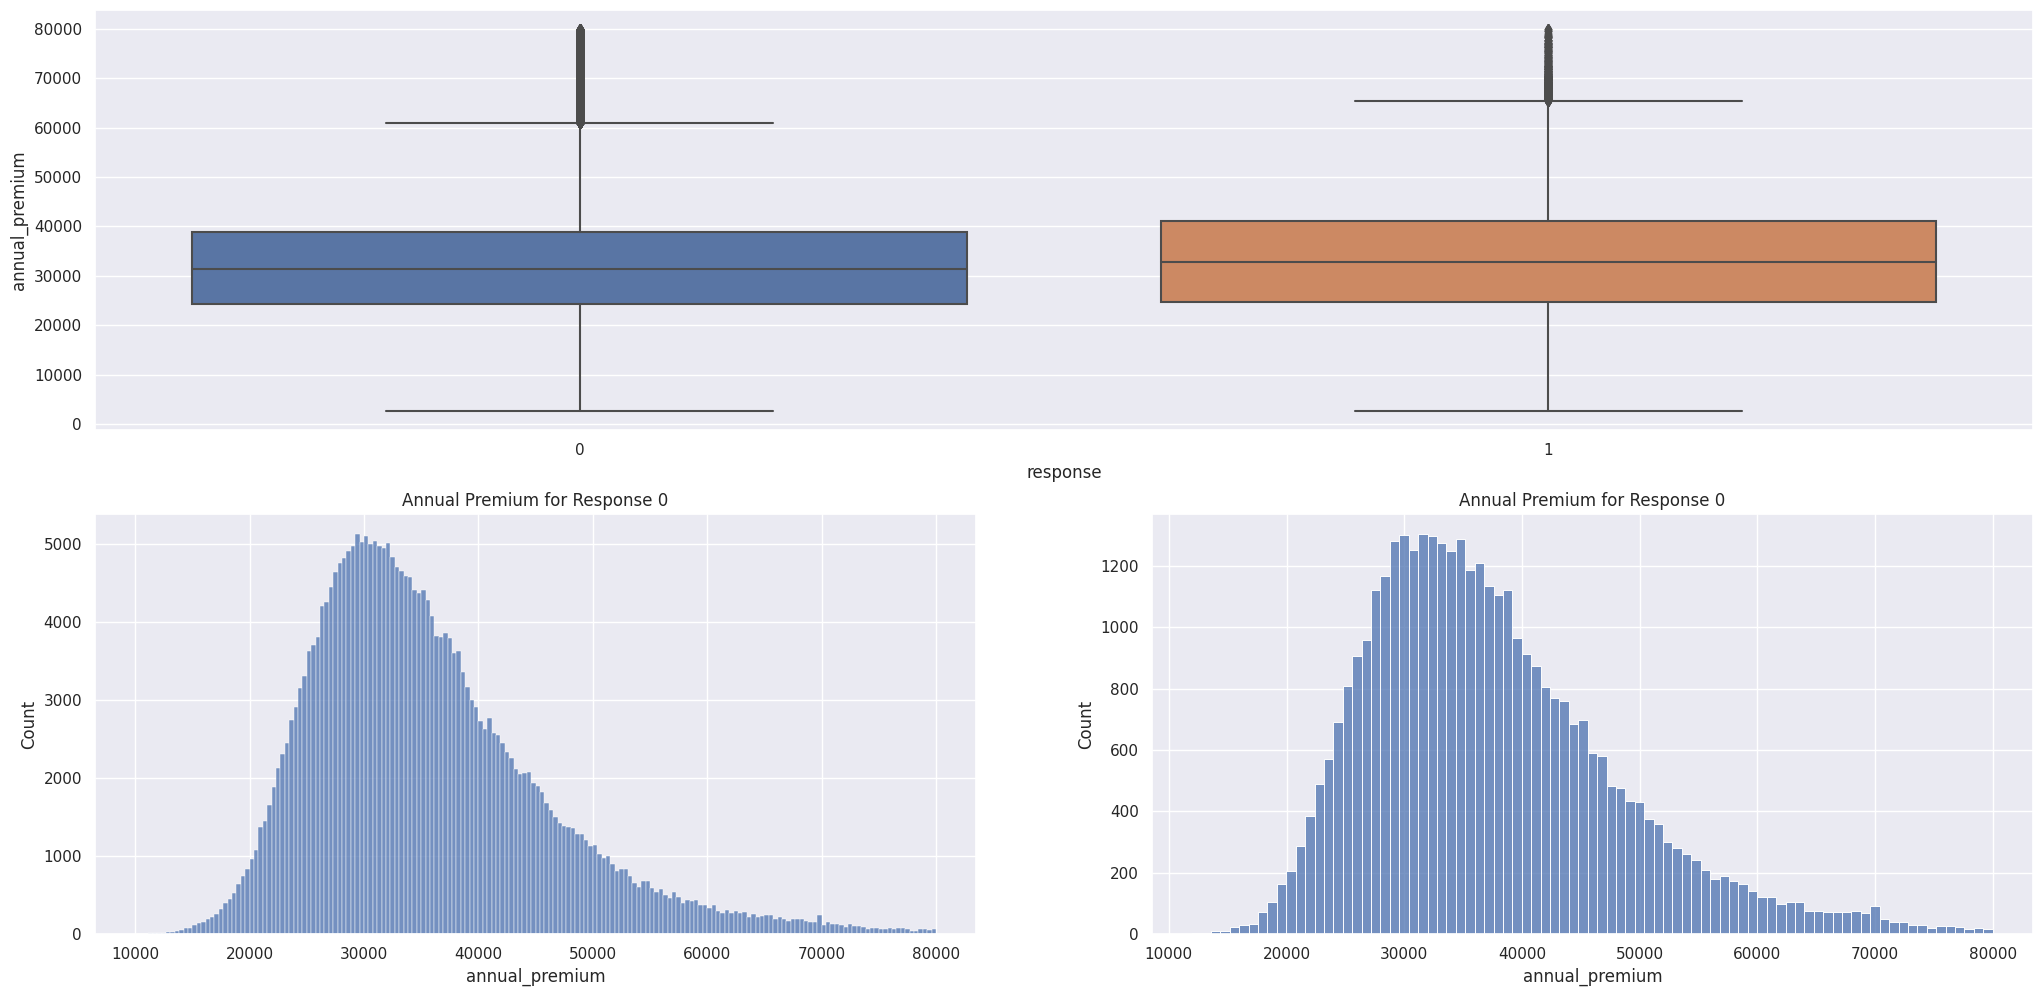

In [22]:
# 'annual_premium'
G = gridspec.GridSpec(2, 2)

aux = df4[df4['annual_premium'] < 80000]
ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='annual_premium', data=aux, ax=ax1)

# Removing outliers for better visualization
aux2 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=aux2[aux2['response'] == 0], x='annual_premium', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=aux2[aux2['response'] == 1], x='annual_premium', ax=ax3)
plt.title('Annual Premium for Response 0');

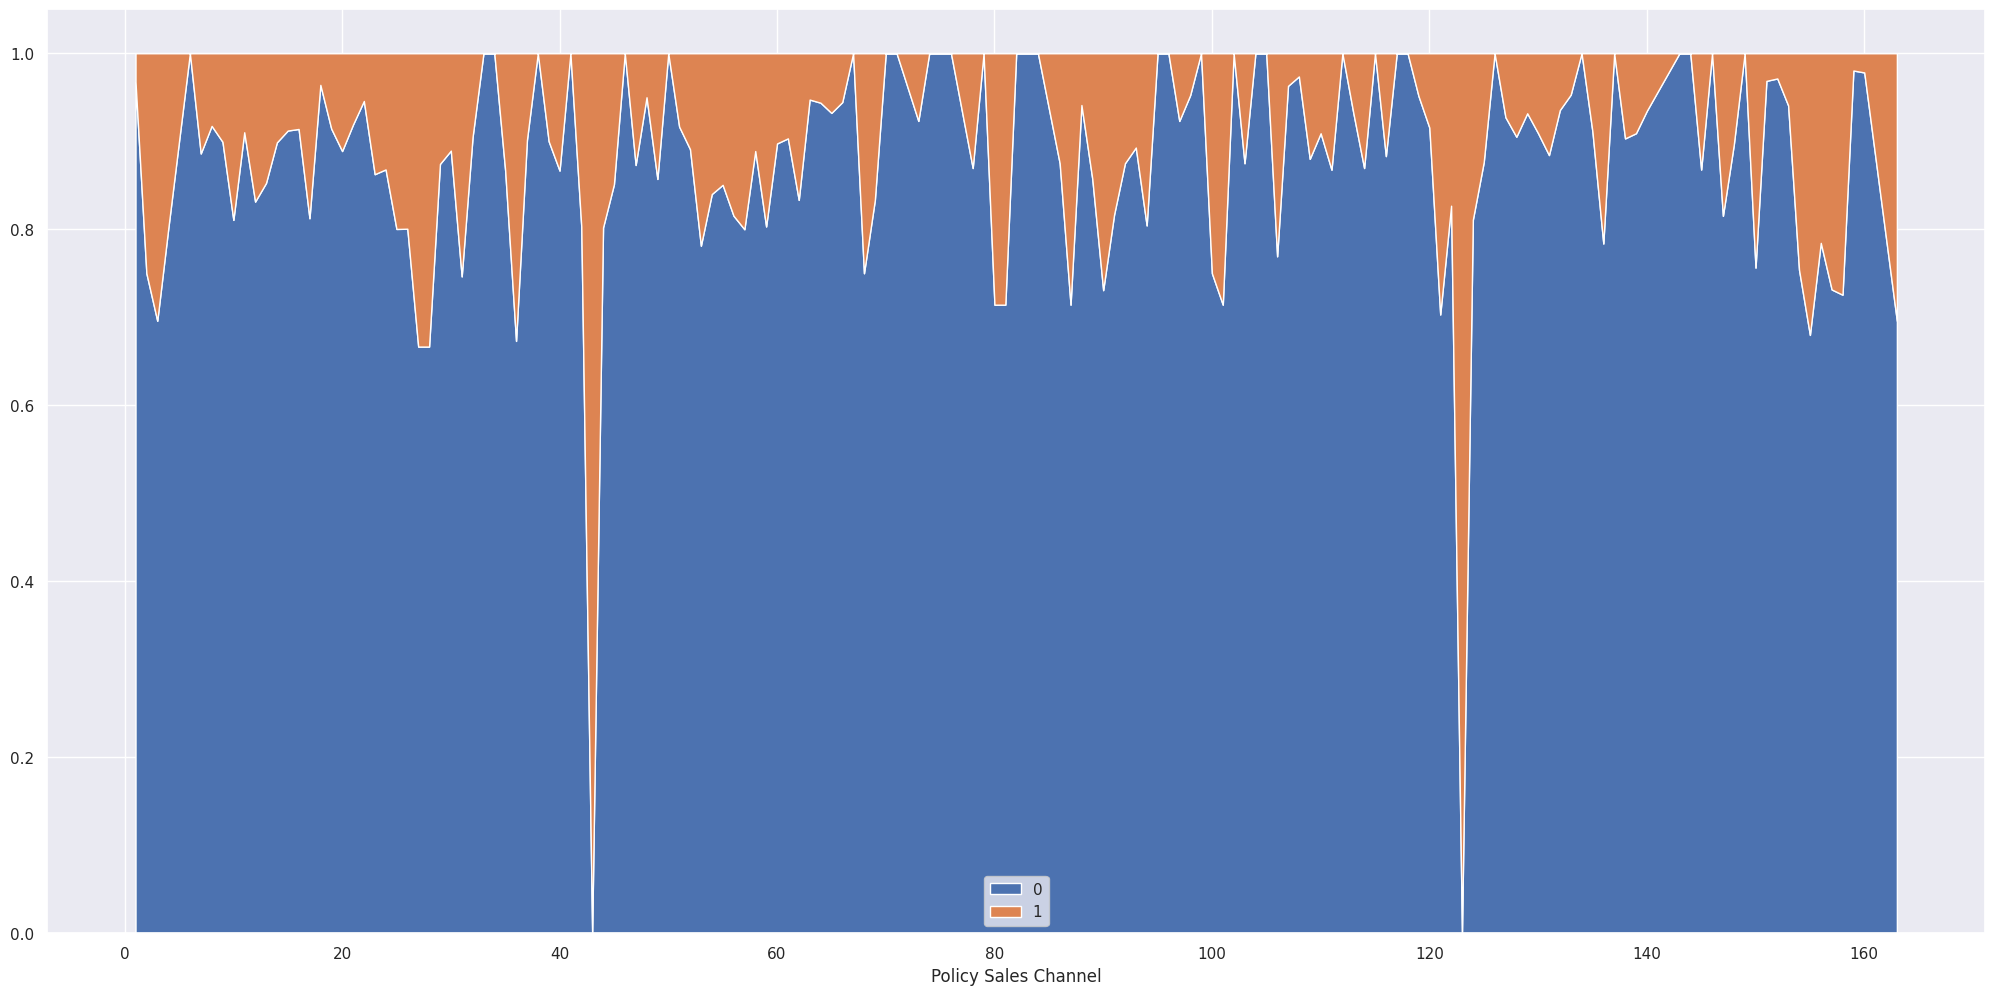

In [23]:
# 'policy_sales_channel'
aux1 = pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()

x = aux1['policy_sales_channel']
y1=aux1[0]
y2=aux1[1]

plt.stackplot(x, y1, y2, labels=['0', '1'])
plt.xlabel('Policy Sales Channel')
plt.legend(loc='lower center');

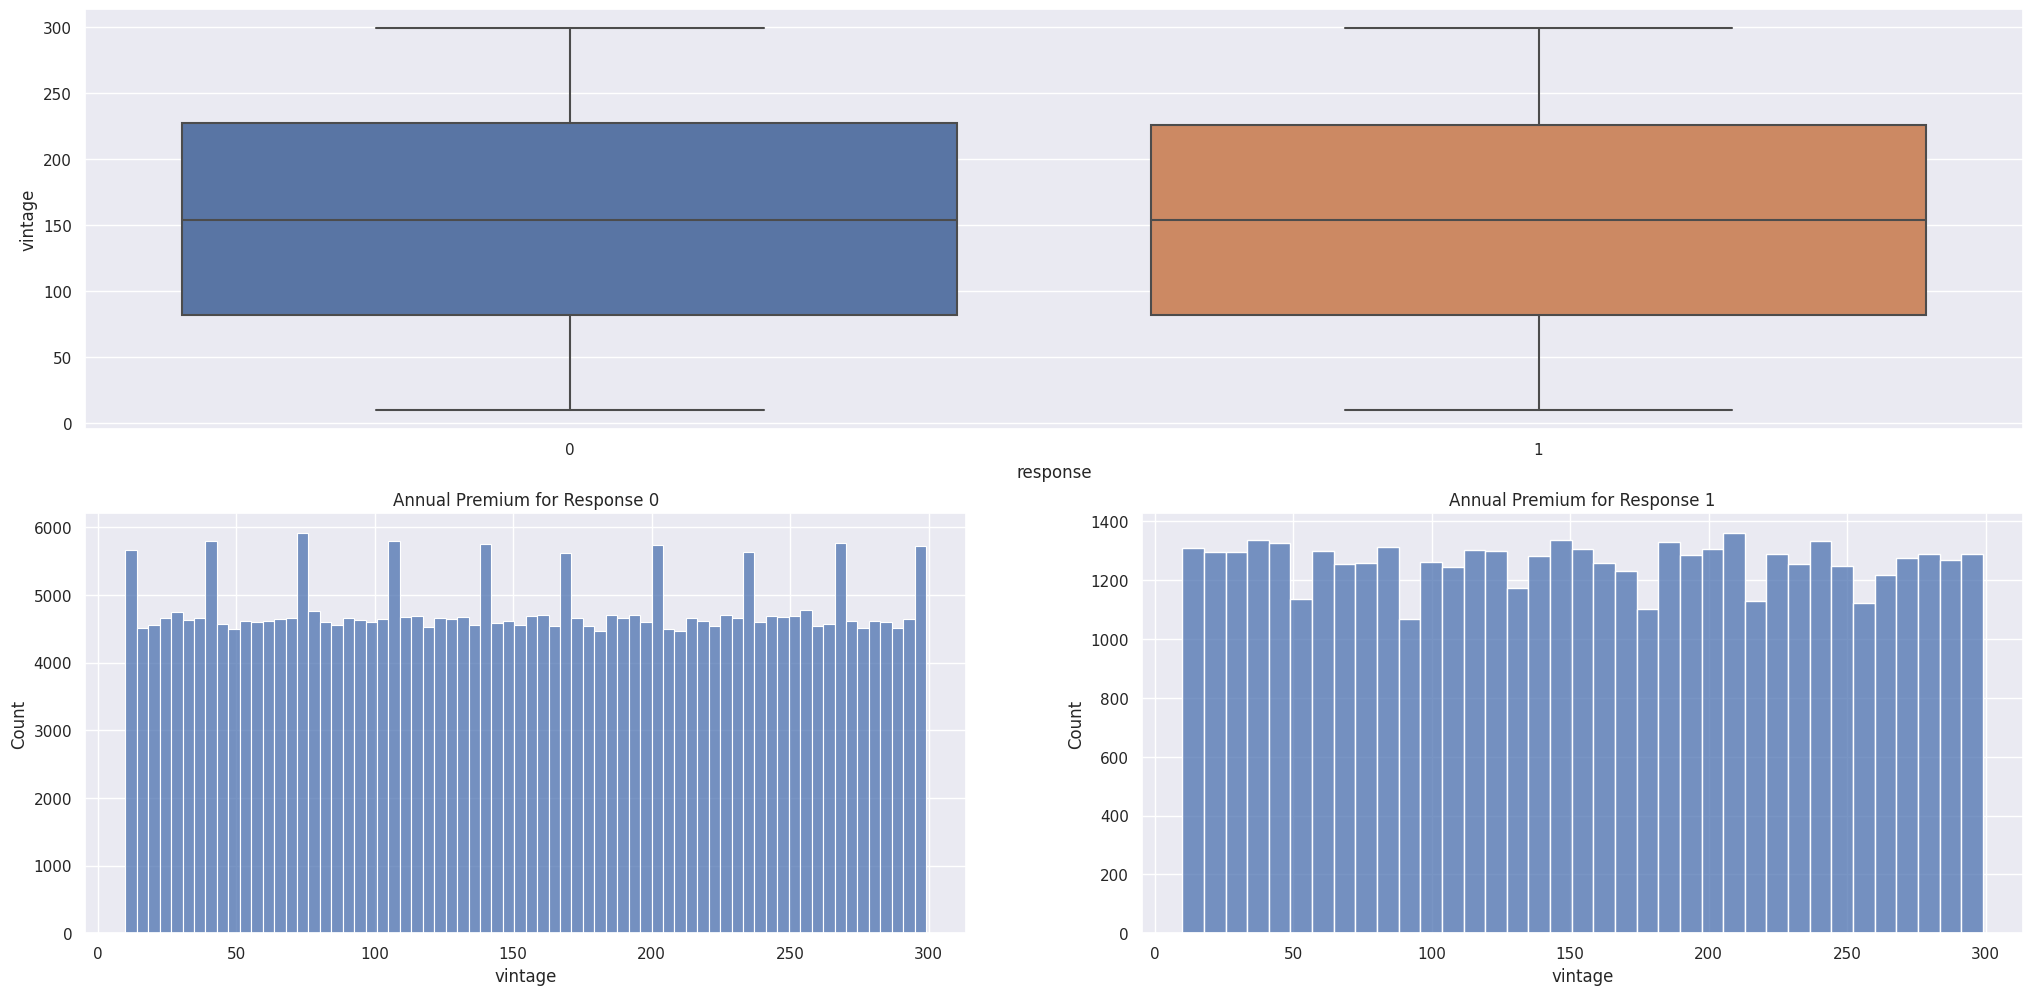

In [24]:
# 'vintage'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x=df4['response'], y=df4['vintage'])

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='vintage', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='vintage', ax=ax3)
plt.title('Annual Premium for Response 1');

# 5.0 DATA PREPARATION

# 5.1 Data Split 

In [133]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y)

df5 = pd.concat([X_train, y_train], axis=1)

## Standardization

In [134]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## Rescaling

In [135]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age (since its distribution is not a normal one)
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## Encoder

In [136]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
288428,288429,Male,0.923077,1,6.0,1,between_1_2_years,1,-1.624501,26.0,0.581315,0
286093,286094,Male,0.692308,1,18.0,0,between_1_2_years,1,-0.020775,26.0,0.698962,1
284602,284603,Female,0.076923,1,8.0,1,below_1_year,0,0.964846,152.0,0.602076,0
169775,169776,Male,0.153846,1,8.0,1,below_1_year,0,0.117487,152.0,0.958478,0
213156,213157,Male,0.400000,1,29.0,1,between_1_2_years,0,0.178303,26.0,0.280277,0


In [137]:
# gender
le = LabelEncoder()
df5['gender'] = le.fit_transform(df5['gender'])


# region_code - Target Enconder
te = TargetEncoder()
df5['region_code'] = df5['region_code'].astype(str)
df5['region_code_encoded'] = te.fit_transform(df5['region_code'], df5['response'])


# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
df5['vehicle_age'] = df5['vehicle_age'].map(vehicle_age_dict)


# policy_sales_channel - Frequency Encoding
df5['policy_sales_channel'] = df5['policy_sales_channel'].astype(str)
cfe = CountFrequencyEncoder(encoding_method='frequency', variables=['policy_sales_channel'])
df5 = cfe.fit_transform(df5)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [138]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,region_code_encoded
288428,288429,1,0.923077,1,6.0,1,2,1,-1.624501,0.209130,0.581315,0,0.070515
286093,286094,1,0.692308,1,18.0,0,2,1,-0.020775,0.209130,0.698962,1,0.135573
284602,284603,0,0.076923,1,8.0,1,1,0,0.964846,0.353984,0.602076,0,0.096552
169775,169776,1,0.153846,1,8.0,1,1,0,0.117487,0.353984,0.958478,0,0.096552
213156,213157,1,0.400000,1,29.0,1,2,0,0.178303,0.209130,0.280277,0,0.123723


# 6.0 FEATURE SELECTION

# 7.0 MACHINE LEARNING